## Second run with IGM

The above example is somewhat limited. In a second run, we are making improvements using `params_1.yaml` instead of `params_0.yaml`:

**First improvement:** Instead of using local data, we use the module `oggm_shop` to download all necessary data. The main advantage is that we can order any glacier using their RGI ID, and therefore get the data for any glacier on Earth!

**Second improvement:** OGGM will download climate data (a time series), which will serve to generate a climate (temperature and precipitation in module `clim_oggm`) to compute a better Surface Mass Balance model. Note this parameter in the parameter file:

```yaml
  clim_oggm:
    clim_trend_array: 
      - ["time", "delta_temp", "prec_scal"]
      - [ 1900,           0.0,         1.0]
      - [ 2020,           0.0,         1.0]
      - [ 2100,           4.0,         1.0]
```

Similar to the previous method, this array assigns weights to modify precipitation and temperature series based on a *neutral* climate period, typically defined as 1960-1990. By adjusting the temperature offset in the `delta_temp` column, for example, a value of -2.0 would create a climate scenario for the 1960-1990 period that is 2 degrees cooler. Likewise, by modifying the precipitation scaling in the `prec_scal` column, a value of 1.5 would result in a climate scenario that has 150% of the precipitation compared to the 1960-1990 average.

Finally, you can incorporate this parameter to provide global control for melt (note that the melt parameters in the PDD model are notoriously uncertain):

```yaml
   melt_enhancer: 0.7
```

Find more information about the generated climate [here](https://igm-model.org/latest/modules/processes/clim_oggm/).

**Third improvement:** Instead of using the Simple Surface Mass Balance `smb_simple`, and now that we have climate available, we will use the `smb_oggm` SMB, which is a monthly temperature index model as described [here](https://igm-model.org/latest/modules/processes/smb_oggm/).

First explore `params_1.yaml`, then run the following command, which will model the Glacier with RGI ID `RGI60-11.01450` (the Great Aletsch Glacier, Switzerland) from 2020 to 2100, assuming a temperature increase of 4 degrees by 2100 relative to 1960–1990:

In [1]:
! igm_run +experiment=params_29oct

2025-10-29 09:57:12.417915: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 09:57:12.442278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-29 09:57:12.442311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-29 09:57:12.442980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-29 09:57:12.446965: I tensorflow/core/platform/cpu_feature_guar

## Visualizing Climate Data

Let's explore the historical climate data that was used for the glacier simulation. We will open the `climate_historical.nc` file and plot the smoothed precipitation and temperature time series on the same graph.

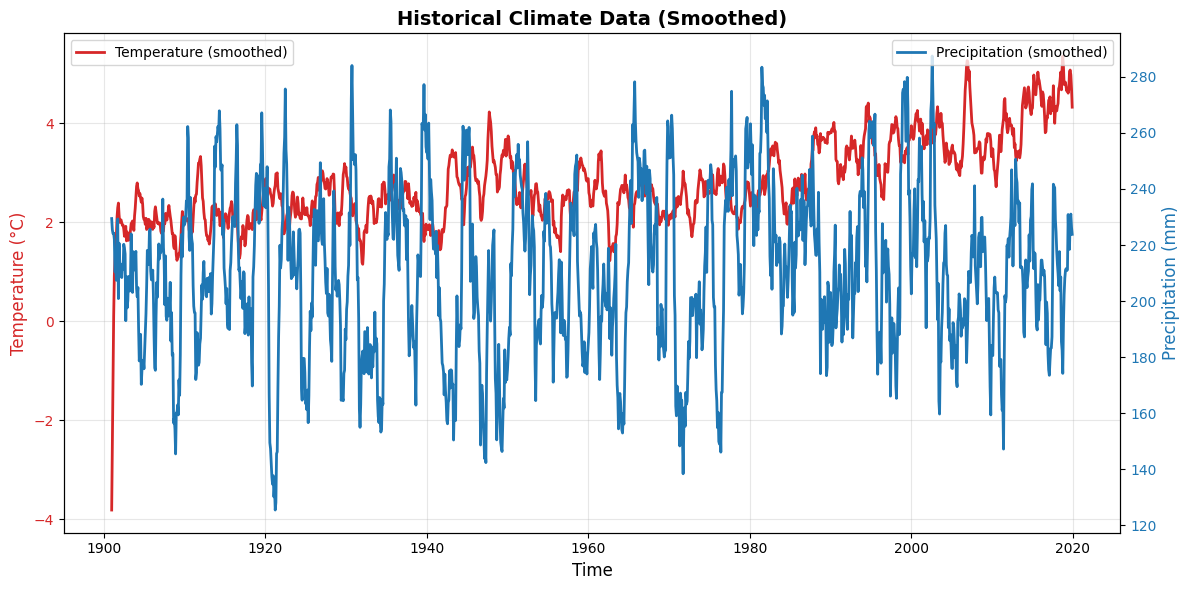


Climate Data Summary:
Time period: 1901-01-01T00:00:00.000000000 to 2019-12-01T00:00:00.000000000
Temperature range: -10.73°C to 15.20°C
Mean temperature: 2.79°C
Precipitation range: 8.13 to 723.20 mm
Mean precipitation: 209.77 mm


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Open the climate data
climate_data = xr.open_dataset('data/RGI2000-v7.0-G-11-01706/climate_historical.nc')

# Extract temperature and precipitation
temp = climate_data['temp'].values
prcp = climate_data['prcp'].values
time = climate_data['time'].values

# Apply smoothing (moving average with window size of 12 months for annual smoothing)
window_size = 12
temp_smoothed = uniform_filter1d(temp, size=window_size, mode='nearest')
prcp_smoothed = uniform_filter1d(prcp, size=window_size, mode='nearest')

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax1.plot(time, temp_smoothed, color=color, linewidth=2, label='Temperature (smoothed)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for precipitation
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precipitation (mm)', color=color, fontsize=12)
ax2.plot(time, prcp_smoothed, color=color, linewidth=2, label='Precipitation (smoothed)')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and layout
plt.title('Historical Climate Data (Smoothed)', fontsize=14, fontweight='bold')
fig.tight_layout()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Display some basic statistics
print(f"\nClimate Data Summary:")
print(f"Time period: {time[0]} to {time[-1]}")
print(f"Temperature range: {temp.min():.2f}°C to {temp.max():.2f}°C")
print(f"Mean temperature: {temp.mean():.2f}°C")
print(f"Precipitation range: {prcp.min():.2f} to {prcp.max():.2f} mm")
print(f"Mean precipitation: {prcp.mean():.2f} mm")

### Analyzing the time series results

Let's examine how the glacier evolved under the climate scenario:

Found 4 time series file(s). Using: outputs/2025-10-29/09-25-05/output_ts.nc

Reading time series data from: /media/gjouvet/storage/Dropbox/home/teaching/25-glacier-modelling/glamod/02_notebook/outputs/2025-10-29/09-25-05/output_ts.nc



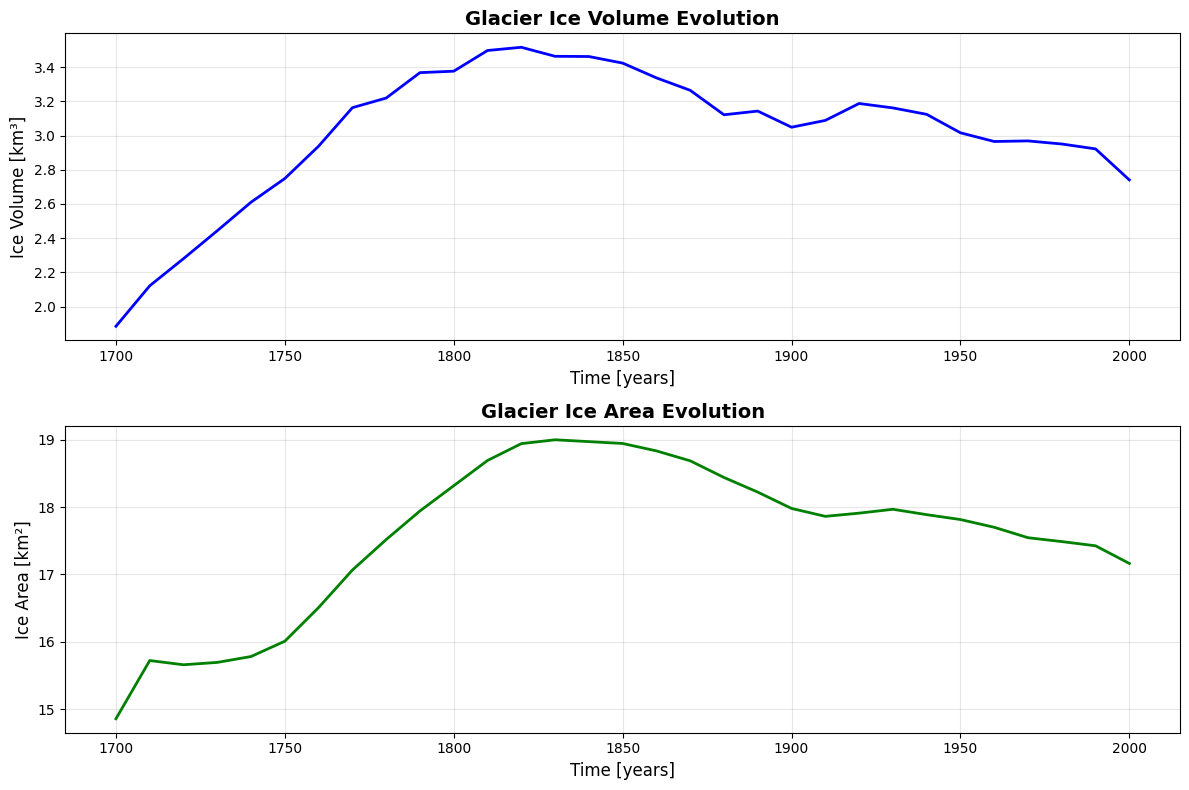


SUMMARY STATISTICS

Ice Volume:
  Initial: 1.88 km³
  Final:   2.74 km³
  Change:  0.86 km³

Ice Area:
  Initial: 14.85 km²
  Final:   17.16 km²
  Change:  2.31 km²


In [9]:
from helper import *
import glob
import os

# Find all time series files and select the most recent one
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    # Get the absolute path to ensure it works from any directory
    ts_file = os.path.abspath(ts_files[-1])
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    # Analyze the time series from the most recent run
    analyze_time_series(ts_file)
else:
    print("No output_ts.nc file found. Please run the model first.")